# OBDELAVA PODATKOV O EVROVIZIJI

## Kazalo

1. [Uvod](#uvod)
2. [Analiza uspeha držav od leta 1994](#uspeh)
3. [Povezava uspeha in bdp](#bdp)
4. [Povezava podeljenih točk in geografske bližine](#meje)
5. [Povzetek](#povzetek)

## Uvod <a name="uvod"></a>

Sem Luka Simčič, študent 2. letnika matematike na FMF. Pri Programiranju 1 sem za projektno nalogo izbral obdelavo podatkov o Evroviziji.

Pred začetkom sem si pripravil 3 vprašanja, ki jih bom raziskoval:
* So bile katere države nadpovprečno / podpovprečno uspešne, ali vse približno enako?
* Obstaja povezava med uspehom države in njeno gospodarsko razvitostjo?
* Obstaja povezava med številom podeljenih točk med dvema državama in njuno geografkso bližino?

Pa začnimo.

Na začetku uvozim potrebne knjižice in svoje podatke.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import pylab as py 
import statsmodels.api as sm
import scipy
import seaborn
import scipy.optimize as opt

pd.options.display.max_rows = 10
%matplotlib inline

bdp = pd.read_csv(os.path.join('podatki', 'bdp.csv'))
meje = pd.read_csv(os.path.join('podatki', 'meje.csv'))
glasovi = pd.read_csv(os.path.join('podatki', 'esc.csv'), sep=';')
uvrstitve = pd.read_csv(os.path.join('podatki', 'uvrstitve.csv'))

Najprej bom uredil tabelo glasovi, da pomečem proč nepomembne stolpce in preimenujem indekse ter države.

In [2]:
glasovi = glasovi.drop(columns=['Edition', '(semi-) final', 'Jury or Televoting'])
glasovi = glasovi.rename(columns={'Year': 'leto', 'From country': 'od države', 'To country': 'državi', 'Points      ' : 'točke', 'Duplicate': 'podvojeno'})
glasovi = glasovi[glasovi['podvojeno'] != 'x'].drop(columns='podvojeno')
glasovi.replace(to_replace=['The Netherands'], value='The Netherlands', inplace=True) # to napako sem opazil že v pridobitvi podatkov
glasovi.replace(to_replace=['North Macedonia'], value='Macedonia', inplace=True)
glasovi.replace(to_replace=['F.Y.R. Macedonia'], value='Macedonia', inplace=True)

Zdaj imam vse tabele pripravljene.

## Analiza uspeha držav od leta 1994 <a name="uspeh"></a>

Zanimalo me bo, če so bile vse države približno enako uspešne, če obstaja kakšen vzorec, kako se je odrezala Slovenija,...

Za ta del imam pripravljeno tabelo uvrstitve:

In [3]:
uvrstitve

,leto,država,točke
0,1994,Austria,19
1,1994,Bosnia & Herzegovina,39
2,1994,Croatia,27
3,1994,Cyprus,51
4,1994,Estonia,2
...,...,...,...
894,2019,Moldova,0
895,2019,Montenegro,0
896,2019,Poland,0
897,2019,Portugal,0


Ustvaril bom novo tabelo s povprečnimi točkami posameznih držav in jo predstavil grafično.

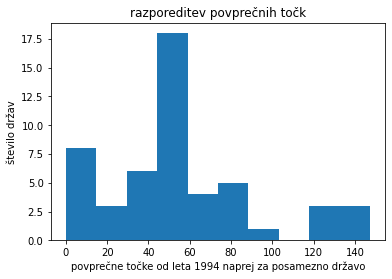

In [4]:
uvrstitve_po_državah = uvrstitve.drop(columns='leto').groupby('država').mean()
točke = uvrstitve_po_državah['točke'].to_numpy()

plt.hist(točke)
plt.title('razporeditev povprečnih točk')
plt.xlabel('povprečne točke od leta 1994 naprej za posamezno državo')
plt.ylabel('število držav')
plt.show()

Največ držav doseže povprečno okoli 50 točk. 

Histogram spominja na normalno porazdelitev. Narišmo najbolje prilegajočo se krivuljo.

Text(0.5, 0, 'točke')

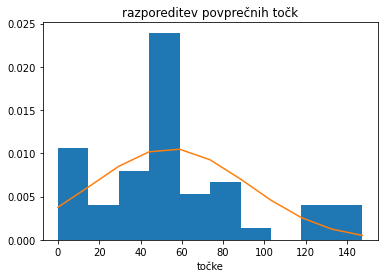

In [5]:
_, bins, _ = plt.hist(točke, density=1)
mu, sigma = scipy.stats.norm.fit(točke)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.title('razporeditev povprečnih točk')
plt.xlabel('točke')

Normalno porazdelitev bom podrobneje testiral na dva načina:

1. #### Q-Q test

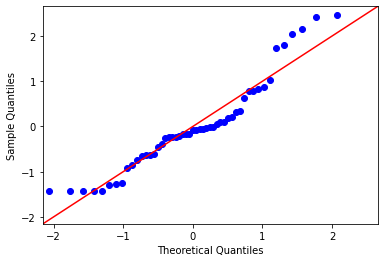

In [6]:
qqplot = sm.qqplot(točke, line='45', fit=True)

Če bi podatki bili normalno porazdeljeni, bi se prilegali rdeči črti. Videti je, da najbolj odstopajo skrajno levo in desno. To pomeni, da je mojih podatkov več v ekstremnih vrednostih, kot bi jih bilo, če bi bila distribucija normalna.

2. #### Shapiro–Wilk test

In [7]:
shapiro_test = scipy.stats.shapiro(točke)
p = shapiro_test.pvalue
print(p)

0.002811499172821641


Majhno odstopanje od normalne porazdelitve pomeni veliko verjetnostno vrednost ali p-vrednost.
Veliko odstopanje ima tako nizko p-vrednost.

Če je p manjše od 0,05, ne verjamemo, da gre za normalno zarporeditev.

Za naše podatke velja `p = 0.002811499172821641`.

Poglejmo še, kako se je odrezala Slovenija.

In [8]:
slo = uvrstitve_po_državah.loc['Slovenia']
print('Slovenija je povprečno dosegla ' + f'{round(float(slo), 2)}' + ' točk. To je podpovprečno.')

print('Najbolj uspešne države:')
uvrstitve_po_državah.sort_values('točke').tail()

Slovenija je povprečno dosegla 26.29 točk. To je podpovprečno.
Najbolj uspešne države:


,točke
država,
Sweden,122.153846
Russia,131.590909
Ukraine,135.666667
Australia,145.600000
Italy,147.400000


## Povezava uspeha in bdp <a name="bdp"></a>

Poleg tabele uvrstitve imam pripravljeno še eno, kjer je za vsako leto in državo podan njen bdp tisto leto.

In [9]:
bdp

,leto,država,bdp
0,1994,United Kingdom,960428
1,1994,Germany,1859310
2,1994,France,1175737
3,1994,Spain,425089
4,1994,Italy,891770
...,...,...,...
1243,2019,Slovenia,12130
1244,2019,Slovakia,13003
1245,2019,San Marino,745
1246,2019,Turkey,108862


Naj opomnim, da je bil za nekatere države v mojem viru podan za vsako leto isti bdp, za nakatere pa ne.

Najprej bom narisal graf doseženih točk v odvisnosti od bdp. Vsaka pika predstavlja povprečje točk, ki so jih dosegle države, ki so poljubno leto imele določen bdp.

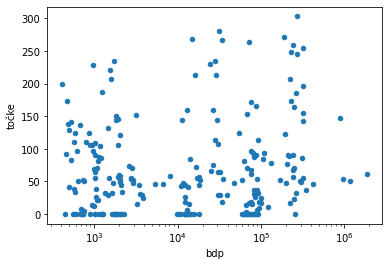

In [10]:
bdp_in_uvrstitve = pd.merge(bdp, uvrstitve).drop(columns='leto')
povprečja_točk_po_bdp = bdp_in_uvrstitve.groupby('bdp', as_index=False).mean()
povprečja_točk_po_bdp.plot.scatter(x = 'bdp', y = 'točke').set_xscale('log')

Iz točk si težko predstavljamo korelacijo, zato poskušajmo podatke aproksimirati s polinomi.

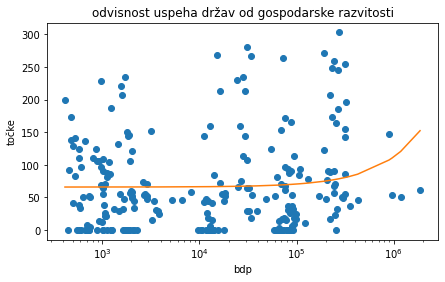

In [11]:
def linearni_polinom(x, a, b):
    return a * x + b

def prilegajoč_se_polinom(polinom):
    koeficienti, _ = opt.curve_fit(polinom, povprečja_točk_po_bdp['bdp'], povprečja_točk_po_bdp['točke'])
    polinom = polinom(povprečja_točk_po_bdp['bdp'], *koeficienti)
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.plot(povprečja_točk_po_bdp['bdp'], povprečja_točk_po_bdp['točke'], 'o')
    ax.plot(povprečja_točk_po_bdp['bdp'], polinom)

    ax.set_xscale('log')
    ax.set_xlabel('bdp')
    ax.set_ylabel('točke')
    ax.set_title('odvisnost uspeha držav od gospodarske razvitosti')
    
prilegajoč_se_polinom(linearni_polinom)

Zdi se, da velja, da so razvitejše države uspešnejše. Aproksimirajmo namesto z linearnim polinomom še s polinomom višje stopnje.

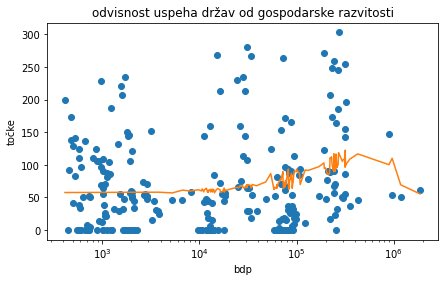

In [12]:
def polinom_visje_stopnje(x, a, b, c, d, e, f):
    return a * x ** 5 + b * x ** 4 + c * x ** 3 + d * x ** 2 + e * x + f

prilegajoč_se_polinom(polinom_visje_stopnje)

Krivulja je načeloma naraščujoča. Izpostavil bi desni del, kjer pade. Poglejmo, zaradi katerih držav se to zgodi (to so tiste z največjim bdp).

In [13]:
države = bdp_in_uvrstitve.groupby('država').mean()
države_ki_kvarijo_krivuljo = države[države.bdp > 9 ** 6]
države_ki_kvarijo_krivuljo

,bdp,točke
država,,
France,1175737.0,51.346154
Germany,1859310.0,62.000000
Italy,891770.0,147.400000
United Kingdom,960428.0,53.730769


Vidimo, da so te države Francija, Nemčija in Velika Britanija. Zanimivo, da se te države izkažejo nesorazmerno svoji gospodarski moči (če bi bila korelacija linearna), čeprav imajo od leta 2000 naprej avtomatsko vstopnico v finale.

Poglejmo si še, katere druge države najbolj odstopajo od linearne aproksimacije.

In [14]:
države['razmerje'] = države.točke / države.bdp
povprečno_razmerje = države.razmerje.mean()

države['odstopanje'] = države.razmerje - povprečno_razmerje
države.sort_values('odstopanje')

,bdp,točke,razmerje,odstopanje
država,,,,
Andorra,1.013000e+03,0.000000,0.000000,-0.012562
Monaco,2.263000e+03,0.000000,0.000000,-0.012562
Germany,1.859310e+06,62.000000,0.000033,-0.012529
France,1.175737e+06,51.346154,0.000044,-0.012518
United Kingdom,9.604280e+05,53.730769,0.000056,-0.012506
...,...,...,...,...
Moldova,1.107067e+03,61.000000,0.055101,0.042538
Bosnia & Herzegovina,1.048944e+03,67.500000,0.064350,0.051788
Azerbaijan,1.809167e+03,120.000000,0.066329,0.053767


K tem podatkom bi dodal le še opombo, da sta Andora in Monako le nekajkrat sodelovala in nikoli prišla v finale. Po drugi strani je zanimivo, da so najuspešnejše države po tem kriteriju ravno Kavkaške države.

## Povezava podeljenih točk in geografske bližine <a name="meje"></a>


Za ta del imam tabelo s podrobnimi glasovi od leta 1975 naprej.

In [15]:
glasovi

,leto,od države,državi,točke
1,1975,Belgium,Finland,0
2,1975,Belgium,France,2
3,1975,Belgium,Germany,0
4,1975,Belgium,Ireland,12
5,1975,Belgium,Israel,1
...,...,...,...,...
49826,2019,Belarus,San Marino,0
49827,2019,Belarus,Greece,3
49828,2019,Belarus,Germany,0
49830,2019,Belarus,The Netherlands,6


Za pregled deljenja točk bom ustvaril matriko, ki bo prikazovala, povprečno koliko točk je posamezna država dala drugim.

In [16]:
države = set(glasovi['od države'].tolist())
matrika = pd.DataFrame(index=države, columns=države)
for državi in države:
    točke = glasovi.query('državi == @državi').groupby('od države')['točke'].aggregate([np.mean])['mean']
    matrika[državi] = round(točke)  
    if državi in države:
        matrika.loc[državi, državi] = float('NaN')
matrika

,Hungary,Belarus,Montenegro,Romania,Australia,Morocco,Andorra,Austria,Azerbaijan,Germany,...,San Marino,Estonia,United Kingdom,Denmark,Bulgaria,Latvia,Italy,Sweden,Yugoslavia,Georgia
Hungary,NaN,2.0,0.0,3.0,5.0,NaN,0.0,3.0,6.0,1.0,...,2.0,2.0,2.0,4.0,6.0,1.0,2.0,3.0,NaN,2.0
Belarus,2.0,NaN,1.0,1.0,4.0,NaN,1.0,2.0,4.0,0.0,...,2.0,3.0,0.0,1.0,4.0,3.0,1.0,3.0,NaN,5.0
Montenegro,2.0,2.0,NaN,2.0,2.0,NaN,0.0,0.0,5.0,0.0,...,3.0,0.0,0.0,2.0,3.0,0.0,5.0,2.0,NaN,0.0
Romania,6.0,1.0,1.0,NaN,3.0,NaN,0.0,2.0,5.0,2.0,...,1.0,1.0,1.0,3.0,3.0,1.0,4.0,3.0,NaN,0.0
Australia,1.0,1.0,1.0,2.0,NaN,NaN,NaN,2.0,1.0,2.0,...,1.0,3.0,3.0,4.0,6.0,3.0,2.0,7.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Latvia,1.0,3.0,0.0,1.0,5.0,NaN,0.0,2.0,3.0,2.0,...,0.0,9.0,1.0,4.0,2.0,NaN,3.0,5.0,NaN,3.0
Italy,1.0,1.0,1.0,6.0,3.0,7.0,NaN,3.0,3.0,3.0,...,2.0,3.0,3.0,3.0,4.0,1.0,NaN,3.0,2.0,1.0
Sweden,3.0,0.0,1.0,2.0,7.0,0.0,0.0,2.0,2.0,3.0,...,0.0,4.0,3.0,6.0,2.0,2.0,2.0,NaN,3.0,1.0
Yugoslavia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,...,NaN,NaN,4.0,1.0,NaN,NaN,6.0,4.0,NaN,NaN


Matriko še vizualno uredim:

<AxesSubplot:title={'center':'porazdelitev točk\n'}, xlabel='države, ki prejmejo točke', ylabel='države, ki dajo točke'>

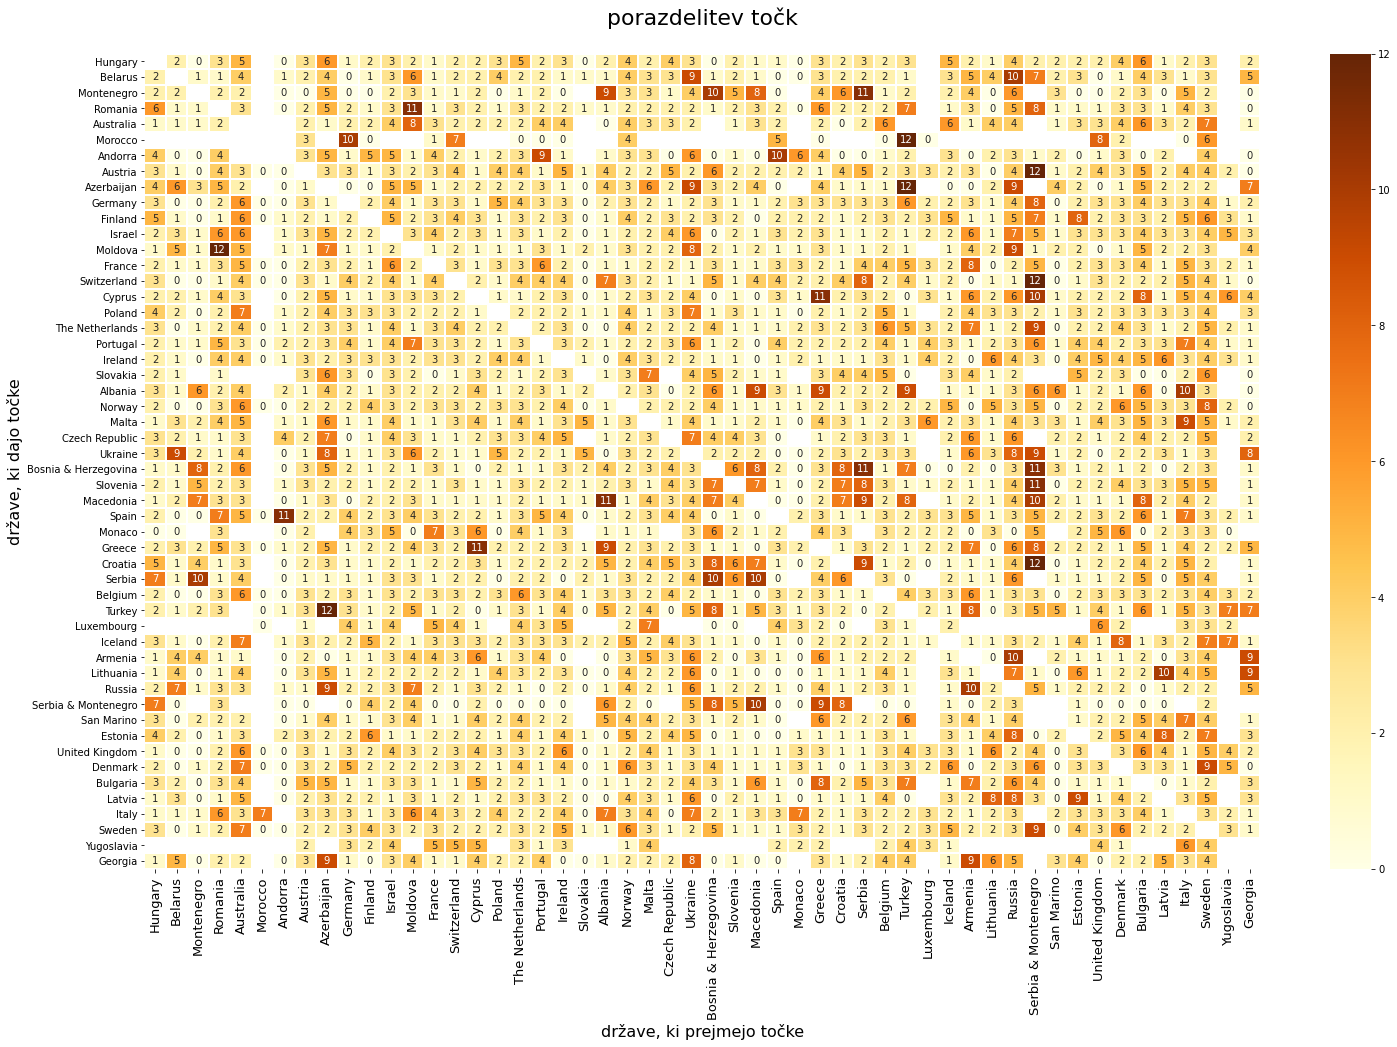

In [17]:
plt.figure(figsize=(25,15))
heatmap = seaborn.heatmap(matrika, annot=True, fmt='g', cmap='YlOrBr', linewidth=1)
heatmap.set_title('porazdelitev točk\n', fontsize=22)
heatmap.tick_params(axis='x', labelrotation=90, labelsize=13)
heatmap.set_xlabel('države, ki prejmejo točke', fontsize=16)
heatmap.tick_params(axis='y')
heatmap.set_ylabel('države, ki dajo točke', fontsize=16)
heatmap

Vidimo, da res izstopajo nekatere sosednje države:
* Severna Makedonija in Albanija
* Romunija in Moldavija
* Grčija in Ciper
* Andora in Španija

Opozoril bi, da so Maroko, Luksemburg in Jugoslavija le nekajkrat sodelovali na Evroviziji oziroma so sodelovali že nekaj desetletji nazaj, ko še ni sodelovalo dosti držav. Zato imajo z malo državami podeljene točke.

Po drugi strani pa je Srbija skupaj s Črno Goro sodelovala le dvakrat in zmeraj zelo uspešno, zato ima nadpovprečno dosti prejetih točk.

Zato bom te tri države odstranil iz matrike.

In [18]:
matrika = matrika.drop(columns=['Morocco', 'Serbia & Montenegro', 'Yugoslavia', 'Luxembourg']) \
                 .drop(['Morocco', 'Serbia & Montenegro', 'Yugoslavia', 'Luxembourg'])

Poglejmo najbolj izstopajoče pare. To so države, ki so dale veliko točk specifično neki drugi državi.

In [19]:
pari = matrika.stack().to_frame('točke')
pari = pari.sort_values(by='točke', ascending=False).head(25)
pari.reset_index(inplace=True)
pari = pari.rename(columns={'level_0': 'od države', 'level_1': 'državi'})
pari

,od države,državi,točke
0,Moldova,Romania,12.0
1,Turkey,Azerbaijan,12.0
2,Azerbaijan,Turkey,12.0
3,Cyprus,Greece,11.0
4,Greece,Cyprus,11.0
...,...,...,...
20,Azerbaijan,Russia,9.0
21,Andorra,Portugal,9.0
22,Armenia,Georgia,9.0
23,Montenegro,Albania,9.0


Vidimo, da je večina parov tudi sosedov. Poglejmo, kolikšen delež prvih 25 parov je sosedov.

Pripravil sem že tabelo z mejami:

In [20]:
meje

,država,meja
0,Albania,Macedonia
1,Albania,Greece
2,Albania,Montenegro
3,Andorra,Spain
4,Andorra,France
...,...,...
173,Malta,[]
174,Australia,[]
175,Israel,[]
176,Cyprus,[]


K parom dodajmo še stolpec, ki preveri, ali sta državi sosedi.

In [21]:
pari = pari.merge(meje, left_on='od države', right_on='država')
pari['sosedi'] = pari.meja == pari.državi
pari = pari.drop(columns=['meja', 'država'])
pari = pari.sort_values('sosedi').drop_duplicates(subset=['od države', 'državi'], keep='last')
pari = pari.sort_values('točke', ascending=False)

n = len(pari[pari['sosedi']])
print(f'Od prvih 25 najboljših prijateljev je {n} sosedov.')

pari

Od prvih 25 najboljših prijateljev je 18 sosedov.


,od države,državi,točke,sosedi
0,Moldova,Romania,12.0,True
3,Turkey,Azerbaijan,12.0,True
8,Azerbaijan,Turkey,12.0,True
28,Macedonia,Albania,11.0,True
44,Bosnia & Herzegovina,Serbia,11.0,True
...,...,...,...,...
71,Armenia,Georgia,9.0,True
14,Azerbaijan,Russia,9.0,True
43,Montenegro,Albania,9.0,True
100,Denmark,Sweden,9.0,False


Torej je večina najboljših prijateljev sosedov. 

Poglejmo še prijatelje, ki niso sosedi.

In [22]:
pari[pari['sosedi'] == False]

,od države,državi,točke,sosedi
16,Greece,Cyprus,11.0,False
15,Cyprus,Greece,11.0,False
68,Armenia,Russia,10.0,False
58,Russia,Armenia,10.0,False
51,Albania,Italy,10.0,False
100,Denmark,Sweden,9.0,False
56,Andorra,Portugal,9.0,False


Vse te države so si geografsko blizu. Poleg tega bi med njimi lahko potegnili kakšne vzporednice glede zgodovine, kulture ali vere.

Za konec še poglejmo, kdo so naši prijatelji. Ustvaril bom dve tabeli, prva bo prikazala države, ki nam dajejo veliko točk, druga pa države, katerim mi podelimo veliko točk.

In [37]:
prijatelji1 = glasovi[glasovi['državi'] == 'Slovenia'].groupby('od države')['točke'] \
        .aggregate([sum]) \
        .sort_values('sum', ascending=False) \
        .rename(columns={'sum': 'vsota točk'})
prijatelji1.head()

,vsota točk
od države,
Croatia,135
Bosnia & Herzegovina,110
Serbia,97
Montenegro,91
Poland,83


In [34]:
prijatelji2 = glasovi[glasovi['od države'] == 'Slovenia'].groupby('državi')['točke'] \
        .aggregate([sum]) \
        .sort_values('sum', ascending=False) \
        .rename(columns={'sum': 'vsota točk'})
prijatelji2.head()

,vsota točk
državi,
Serbia,185
Croatia,184
Sweden,180
Bosnia & Herzegovina,151
Denmark,122


Opazi se Yugo nostalgija. Dali in dobili smo največ točk ravno od držav bivše Jugoslavije.

# Povzetek <a name="povzetek"></a>

Zdaj lahko odgovorim na začetna vprašanja:
* Države niso bile vse približno enako uspešne, temveč je njihov uspeh približno normalno razporejen.
* Načeloma velja, da iz boljše gospodarkse razvitosti sledi večji uspeh.
* Geografska bližina ima velik pozitiven vpliv na glasovanje, saj je večina držav, ki si med sabo dajo povprečno največ točk, sosednjih.

Poleg tega sem ugotovil, da gre Sloveniji podpovprečno dobro in da si največ glasov izmenjamo z državami bivše Jugoslavije.